# Puerto Rico Migration Analysis

This notebook explores migration patterns and demographic trends using the provided IPUMS USA dataset. We focus on population trends, age, income, education, and employment, with specific attention to Puerto Rico-born individuals.

**Note**: Generated graphs are exported to the `graphs/` directory.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import os

# Set visualization style
sns.set_theme(style="whitegrid", context="talk", palette="viridis")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# Ensure graphs directory exists
output_dir = '../graphs'
os.makedirs(output_dir, exist_ok=True)

# Helper function for number formatting
def format_thousands(x, pos):
    return '{:,.0f}'.format(x)

# Helper function for currency formatting
def format_currency(x, pos):
    return '${:,.0f}'.format(x)

In [18]:
# Load the dataset
file_path = '../data/usa_00001.csv'
df = pd.read_csv(file_path)

# Display basic info
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1485694, 48)


,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,GQ,FARM,OWNERSHP,OWNERSHPD,MORTGAGE,...,INCTOT,FTOTINC,POVERTY,OCCSCORE,SEI,MIGRATE1,MIGRATE1D,MOVEDIN,VETSTAT,VETSTATD
0,1910,191001,101,NaN,5.0,1,2.0,1,10,1,...,NaN,NaN,NaN,14.0,14.0,NaN,NaN,NaN,NaN,NaN
1,1910,191001,101,NaN,5.0,1,2.0,1,10,1,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1910,191001,101,NaN,5.0,1,2.0,1,10,1,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1910,191001,101,NaN,5.0,1,2.0,1,10,1,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1910,191001,101,NaN,5.0,1,2.0,1,10,1,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


## Data Preparation & Definitions
- **YEAR**: Census year
- **BPL**: Birthplace (We assume 110 = Puerto Rico)
- **INCTOT**: Total personal income (Adjusted to exclude codes for 'N/A' usually 9999999)
- **EDUC**: Education level
- **EMPSTAT**: Employment status

We will clean special codes for income and define labels for clarity.

In [19]:
# Clean Income: Remove special codes (e.g., 9999999 for N/A)
df['INCTOT_CLEAN'] = df['INCTOT'].apply(lambda x: x if x < 999999 else None)

# Map Sex for better labels
df['SEX_LABEL'] = df['SEX'].map({1: 'Male', 2: 'Female'})

# Map Employment Status (simplified)
emp_map = {1: 'Employed', 2: 'Unemployed', 3: 'Not in Labor Force'}
df['EMPSTAT_LABEL'] = df['EMPSTAT'].map(emp_map)

# Identify Puerto Rico Born (BPL = 110)
df['IS_PR_BORN'] = df['BPL'] == 110

## 1. Population Trends

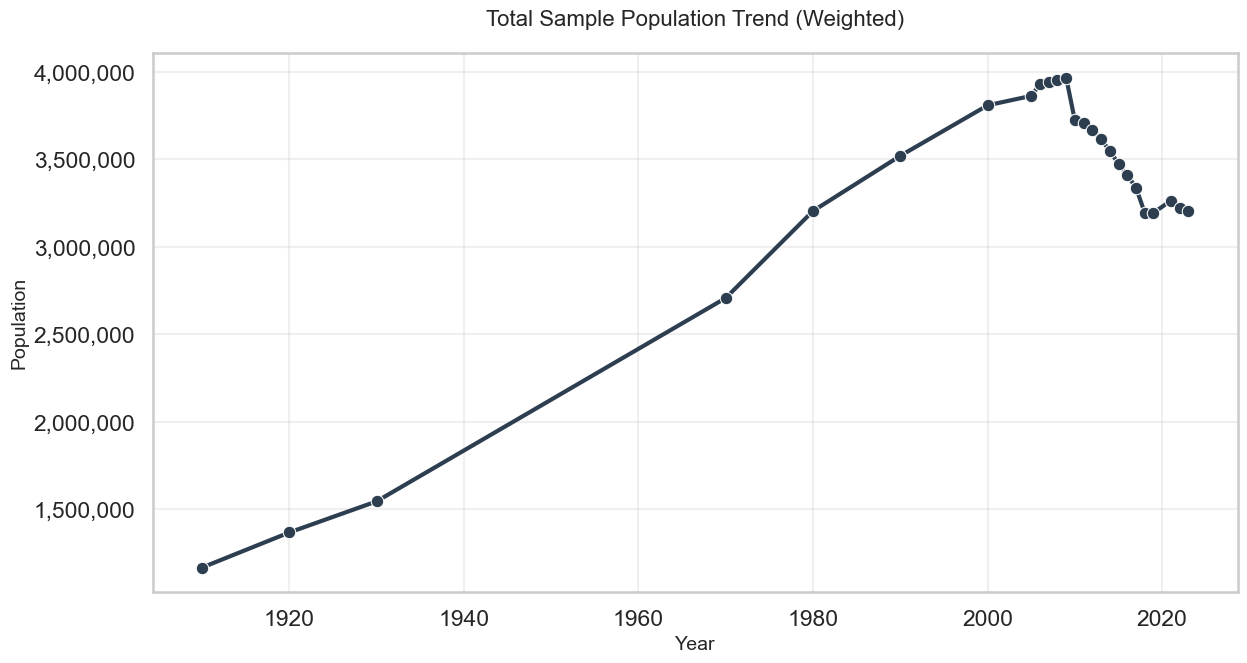

In [20]:
# Weighted Population over Years
yearly_pop = df.groupby('YEAR')['PERWT'].sum().reset_index()

plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=yearly_pop, x='YEAR', y='PERWT', marker='o', linewidth=3, color='#2c3e50')

plt.title('Total Sample Population Trend (Weighted)', pad=20)
plt.xlabel('Year')
plt.ylabel('Population')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
plt.grid(True, alpha=0.3)

# Save plot
plt.savefig(f'{output_dir}/1_total_population_trend.png', bbox_inches='tight', dpi=300)
plt.show()

## 2. Puerto Rico Born Population Analysis

/var/folders/h_/bwlq6y0534d7s34l733j5q_h0000gn/T/ipykernel_99660/3715115574.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=pr_yearly, x='YEAR', y='PERWT', palette='Blues_d')


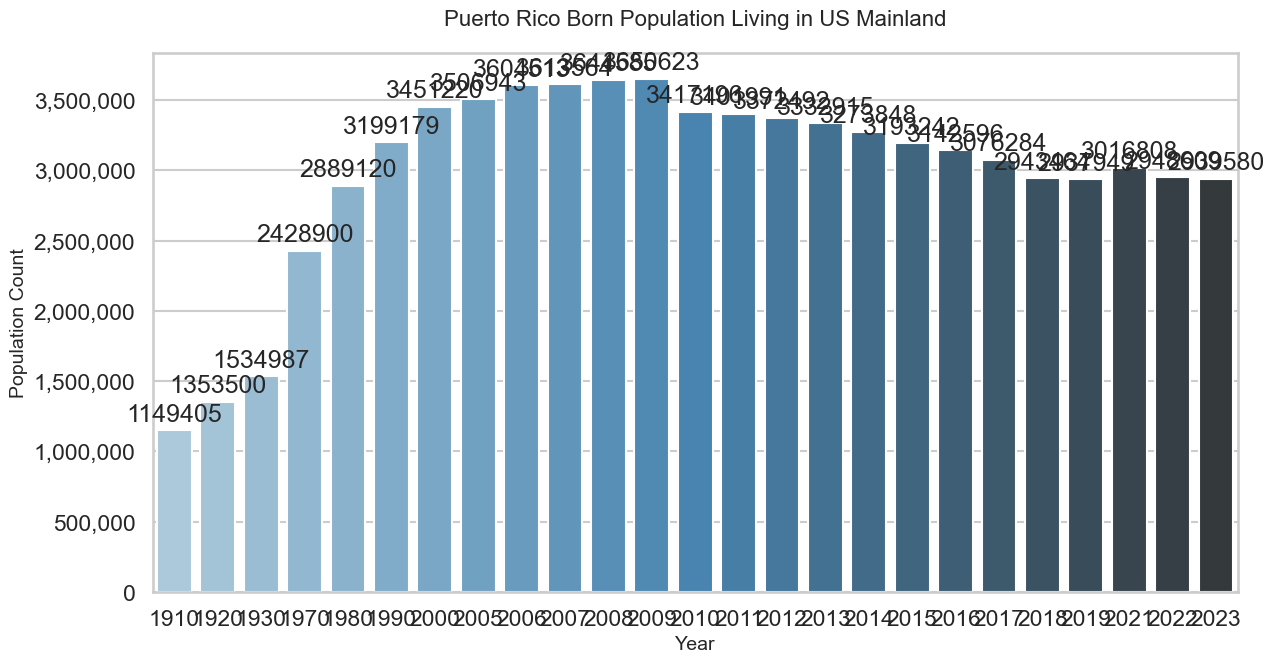

In [21]:
pr_data = df[df['IS_PR_BORN']]

if not pr_data.empty:
    pr_yearly = pr_data.groupby('YEAR')['PERWT'].sum().reset_index()

    plt.figure(figsize=(14, 7))
    ax = sns.barplot(data=pr_yearly, x='YEAR', y='PERWT', palette='Blues_d')
    
    plt.title('Puerto Rico Born Population Living in US Mainland', pad=20)
    plt.xlabel('Year')
    plt.ylabel('Population Count')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))
    
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%d', padding=3)
        
    plt.savefig(f'{output_dir}/2_pr_born_population.png', bbox_inches='tight', dpi=300)
    plt.show()
else:
    print("No data found for Puerto Rico born individuals (BPL=110).")

## 3. Socio-Economic Indicators

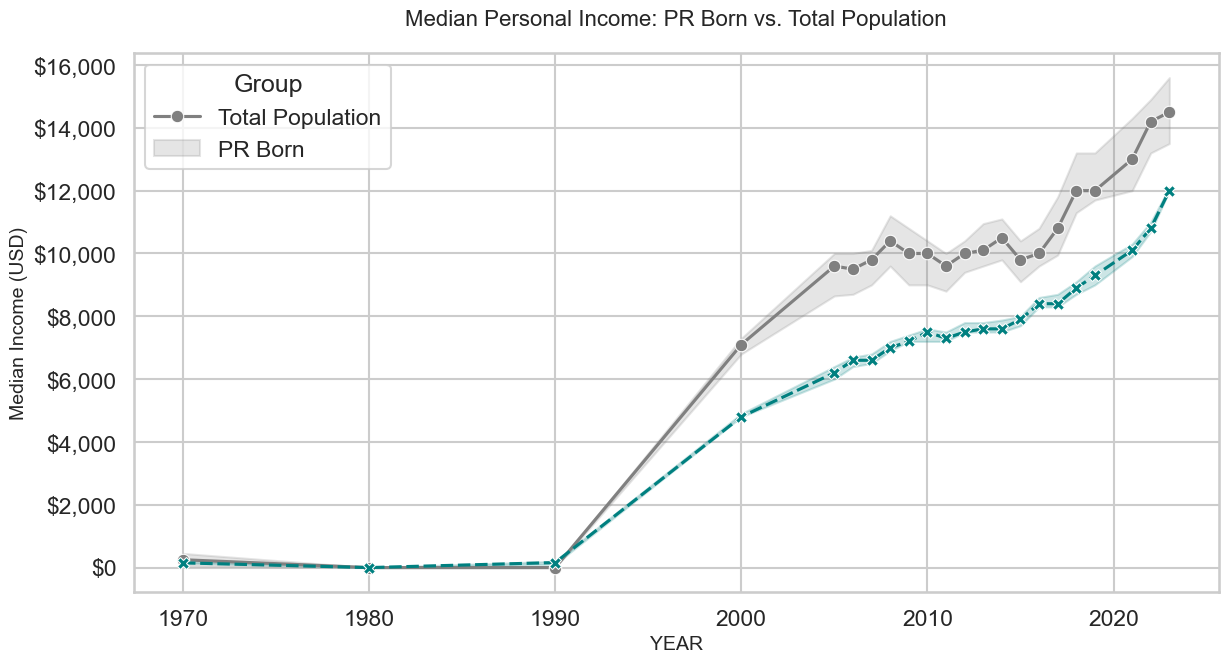

In [22]:
# Median Income Comparison: PR Born vs Others
income_comp = df[df['INCTOT_CLEAN'].notna()]

plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=income_comp, 
    x='YEAR', 
    y='INCTOT_CLEAN', 
    hue='IS_PR_BORN', 
    style='IS_PR_BORN',
    estimator='median',
    markers=True,
    palette=['gray', 'teal']
)

plt.title('Median Personal Income: PR Born vs. Total Population', pad=20)
plt.ylabel('Median Income (USD)')
plt.legend(title='Group', labels=['Total Population', 'PR Born'])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_currency))

plt.savefig(f'{output_dir}/3_median_income_comparison.png', bbox_inches='tight', dpi=300)
plt.show()

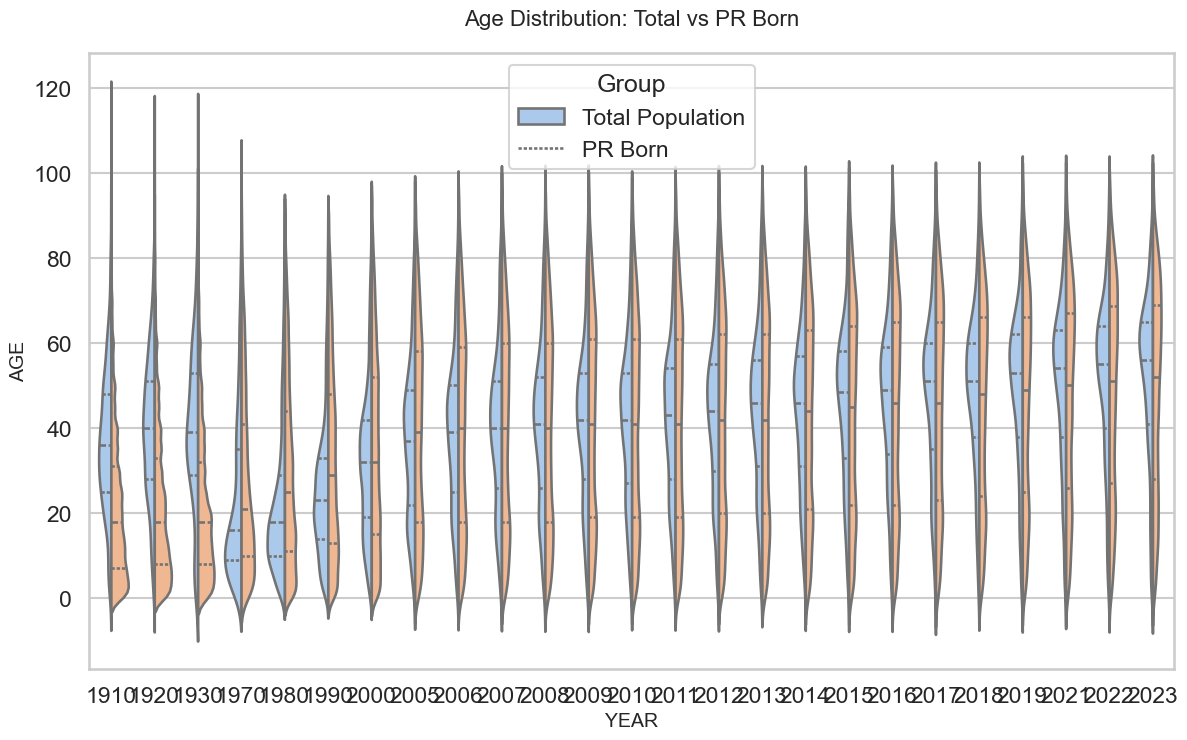

In [23]:
# Age Distribution by Year (Violin Plot for better density visualization)
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x='YEAR', y='AGE', hue='IS_PR_BORN', split=True, palette='pastel', inner='quart')

plt.title('Age Distribution: Total vs PR Born', pad=20)
plt.legend(title='Group', labels=['Total Population', 'PR Born'])

plt.savefig(f'{output_dir}/4_age_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

## 4. Employment Status

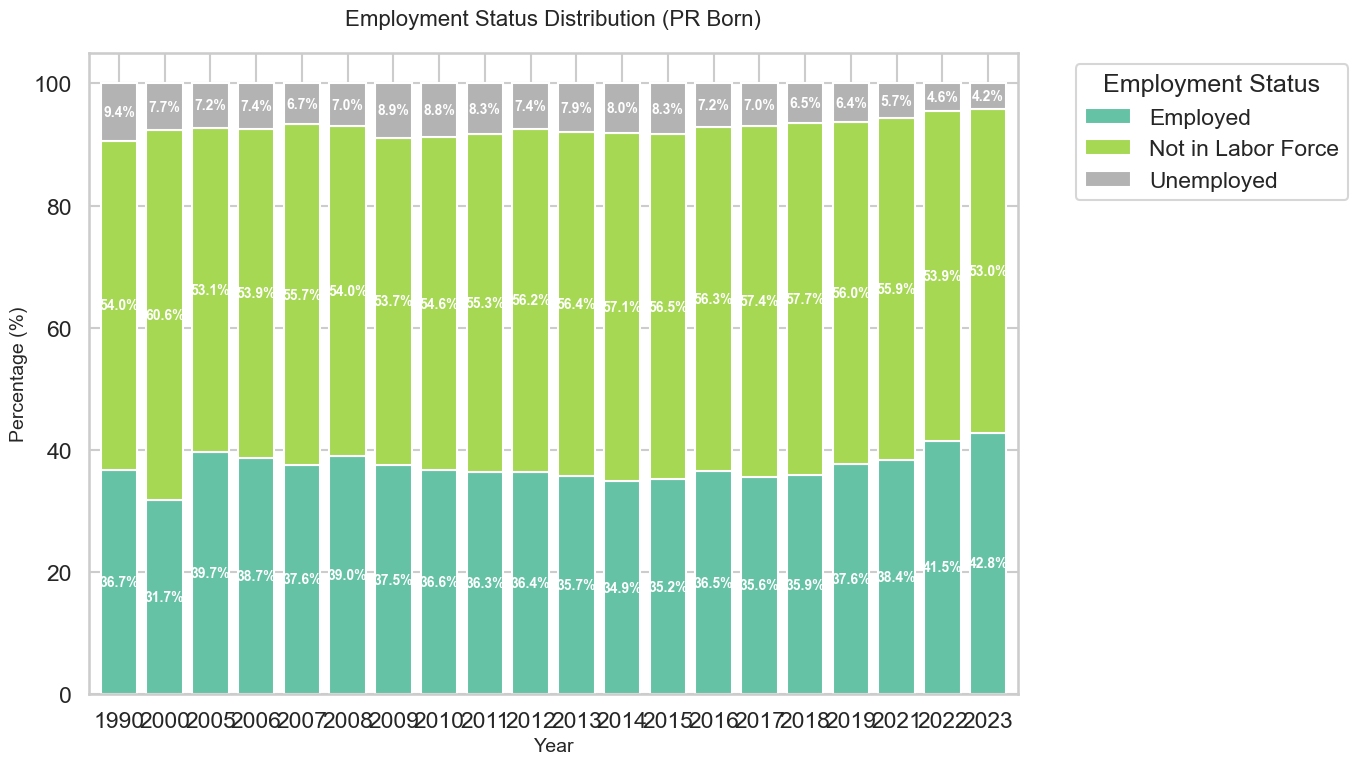

In [24]:
# Employment Status Distribution for PR Born Population over time (Stacked Bar Chart)
if not pr_data.empty:
    # Group by Year and Employment Status, summing weights
    emp_counts = pr_data.groupby(['YEAR', 'EMPSTAT_LABEL'])['PERWT'].sum().reset_index()
    
    # Pivot data for stacked plotting: Index=Year, Columns=Status, Values=Weight
    emp_pivot = emp_counts.pivot(index='YEAR', columns='EMPSTAT_LABEL', values='PERWT')
    
    # Convert to percentages across the row
    emp_pct = emp_pivot.div(emp_pivot.sum(axis=1), axis=0) * 100
    
    # Plotting
    ax = emp_pct.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Set2', width=0.8)
    
    plt.title('Employment Status Distribution (PR Born)', pad=20)
    plt.ylabel('Percentage (%)')
    plt.xlabel('Year')
    plt.legend(title='Employment Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    
    # Add percentage labels inside bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f%%', label_type='center', color='white', fontsize=10, weight='bold')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/5_employment_status_stacked.png', bbox_inches='tight', dpi=300)
    plt.show()

## 5. Education Levels

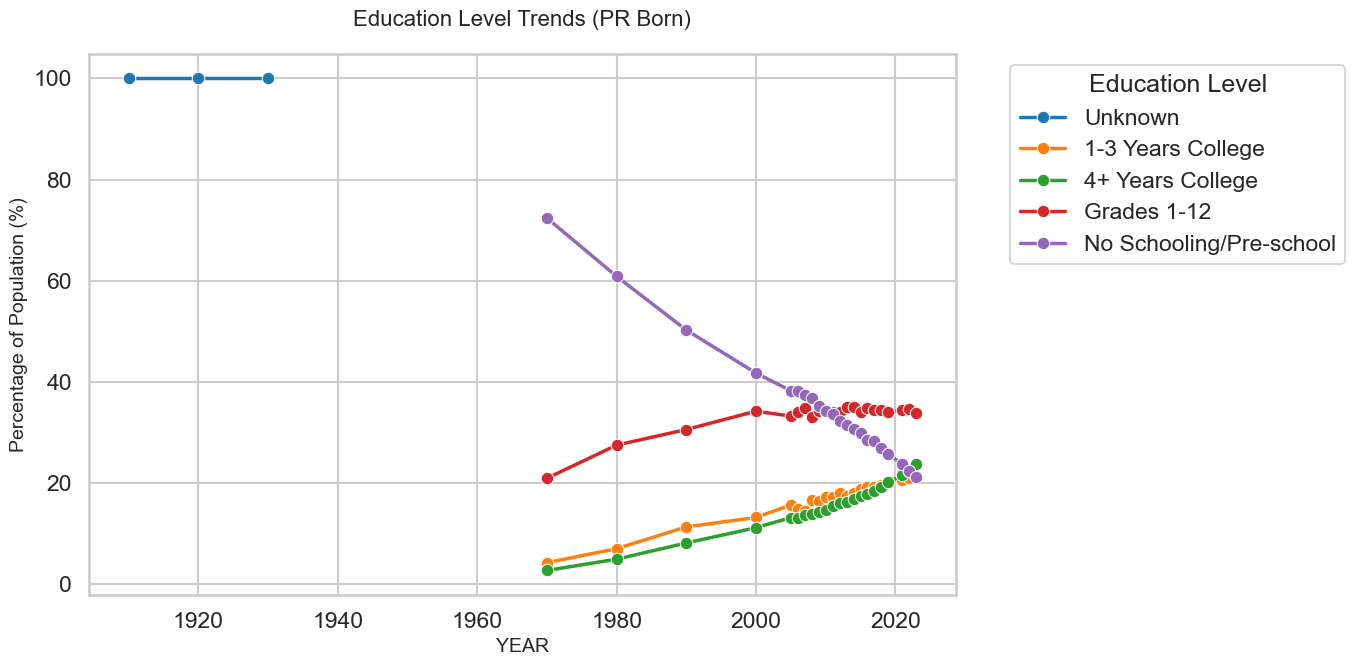

In [25]:
# Map Education (Generalized for plotting)
# IPUMS EDUC codes: 00=NA, 01=Nursery, ..., 06=Grade 12, 07=1 yr college, 10=4 yr college, 11=5+ yr college
def group_education(code):
    if code <= 2: return 'No Schooling/Pre-school'
    if code <= 6: return 'Grades 1-12'
    if code <= 9: return '1-3 Years College'
    if code >= 10: return '4+ Years College'
    return 'Unknown'

df['EDUC_GROUP'] = df['EDUC'].apply(group_education)

# Plot Education trends for PR Born
if not pr_data.empty:
    df_pr = df[df['IS_PR_BORN']]
    educ_counts = df_pr.groupby(['YEAR', 'EDUC_GROUP'])['PERWT'].sum().reset_index()
    educ_counts['PERCENT'] = educ_counts.groupby('YEAR')['PERWT'].transform(lambda x: x / x.sum() * 100)

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=educ_counts, x='YEAR', y='PERCENT', hue='EDUC_GROUP', marker='o', linewidth=2.5, palette='tab10')
    
    plt.title('Education Level Trends (PR Born)', pad=20)
    plt.ylabel('Percentage of Population (%)')
    plt.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    plt.savefig(f'{output_dir}/6_education_trends.png', bbox_inches='tight', dpi=300)
    plt.show()